[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hihos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hihos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter an abstract to generate topics:  The project seeks the convergence of synthetic biology, bioelectronics, and machine learning approaches to provide point-of-use sensors for assessing water quality with broad implications for public health and environmental protection. The primary results of this activity will be new low-cost sensing systems for assessing chemicals in water as applied throughout the water cycle, including waste-water treatment monitoring, drinking-water monitoring, industrial water use, and storm-water discharges in one of the largest metropolitan regions in the world, New York City. This work engages the public sector through the participation of the New York City Department of Environmental Protection as well as university and industry partners. The result of these convergence research activities will be a framework for quickly developing microbial-based biosensors to detect broad classes of analytes, while interfacing to complementary metal-oxide-semiconductor 

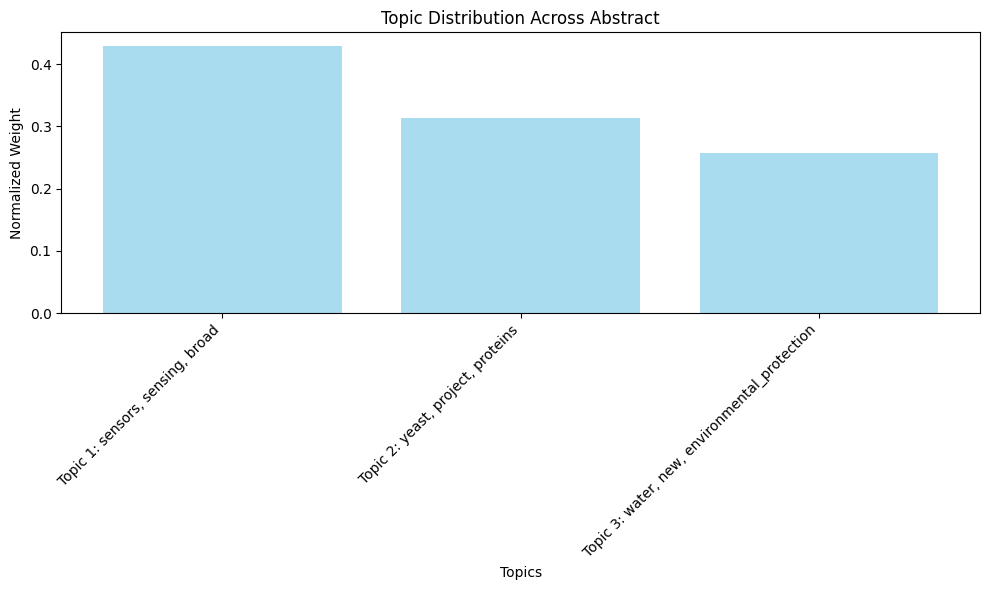

Topic 1: 0.021*"sensors" + 0.021*"sensing" + 0.012*"broad"
Topic 2: 0.030*"yeast" + 0.030*"project" + 0.030*"proteins"
Topic 3: 0.037*"water" + 0.029*"new" + 0.020*"environmental_protection"


In [1]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
import nltk
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def identify_topics_with_lda(abstract, num_topics=3, num_words=3):
    # Tokenize and preprocess the abstract into pseudo-documents
    sentences = sent_tokenize(abstract)
    stop_words = set(stopwords.words('english'))
    
    tokenized_docs = []
    for sentence in sentences:
        tokens = word_tokenize(sentence.lower())
        cleaned_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
        tokenized_docs.append(cleaned_tokens)
    
    # Create bigram and trigram models
    bigram = Phrases(tokenized_docs, min_count=2, threshold=10)  # Adjust `min_count` and `threshold` as needed
    trigram = Phrases(bigram[tokenized_docs], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)
    
    # Apply the bigram and trigram models to tokens
    tokenized_docs_with_phrases = [trigram_phraser[bigram_phraser[doc]] for doc in tokenized_docs]
    
    # Prepare the data for LDA
    dictionary = Dictionary(tokenized_docs_with_phrases)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs_with_phrases]
    
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
    # Extract the topics
    topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    
    # Plot topic distribution
    plot_topic_distribution(lda_model, corpus, num_topics)
    
    return topics

def plot_topic_distribution(lda_model, corpus, num_topics):
    """
    Plots a bar chart showing topic distribution with meaningful labels.
    """
    # Aggregate topic weights across all pseudo-documents
    topic_weights = [0] * num_topics
    for doc_topics in lda_model[corpus]:
        for topic_id, weight in doc_topics:
            topic_weights[topic_id] += weight
    
    # Normalize topic weights for visibility
    total_weight = sum(topic_weights)
    topic_weights = [weight / total_weight for weight in topic_weights]
    
    # Create topic labels using top keywords
    topic_labels = []
    for topic_id in range(num_topics):
        keywords = lda_model.show_topic(topic_id, topn=3)
        label = ", ".join([word for word, weight in keywords])
        topic_labels.append(f"Topic {topic_id + 1}: {label}")
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(topic_labels, topic_weights, color='skyblue', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Topics')
    plt.ylabel('Normalized Weight')
    plt.title('Topic Distribution Across Abstract')
    plt.tight_layout()
    plt.show()

# Execute processing
abstract = input("Enter an abstract to generate topics: ")
topics = identify_topics_with_lda(abstract)
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")